In [1]:
# Cell 1: Import libraries
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, LambdaCallback
from tensorflow.keras.optimizers import Adam
import pyttsx3
import threading
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM
# Print the version of each library
print("OpenCV version:", cv2.__version__)
print("NumPy version:", np.__version__)
print("MediaPipe version:", mp.__version__)
print("tensorflow version:", tf.__version__)


OpenCV version: 4.11.0
NumPy version: 1.23.5
MediaPipe version: 0.10.5
tensorflow version: 2.15.0


In [2]:
# Cell 2: Initialize Mediapipe models 
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities
mp_face_mesh = mp.solutions.face_mesh  # Face Mesh model

In [3]:
# Cell 3: Mediapipe detection function 
def mediapipe_detection(image, model): 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB 
    image.flags.writeable = False # Image is no longer writeable 
    results = model.process(image) # Make prediction 
    image.flags.writeable = True # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR 
    return image, results

In [4]:
# Cell 4: Draw landmarks function
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_face_mesh.FACEMESH_TESSELATION,) # Draw face connections
    # mp_drawing.draw_landmarks(image, results.face_landmarks, mp_face_mesh.FACEMESH_CONTOURS,) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [5]:
# Cell 5: Draw styled landmarks function
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_face_mesh.FACEMESH_TESSELATION, 
    # mp_drawing.draw_landmarks(image, results.face_landmarks, mp_face_mesh.FACEMESH_CONTOURS,
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [7]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        if not ret:
            break  # Break if frame not captured successfully
        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Wait for user input
        key = cv2.waitKey(5) & 0xFF  # 5ms wait, mask with 0xFF to get the key
        if key == ord('y'):  # If 'y' key is pressed
            # Save the image
            filename = "captured_image.png"  # Customize your filename
            cv2.imwrite(filename, image)  # Save the image to disk
            print(f"Image saved as {filename}")
            
            image_count += 1  # Increment the counter
        
        # Exit gracefully when 'q' is pressed
        if key == ord('q'):
            break

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>


In [8]:
cap.release()
cv2.destroyAllWindows()

In [9]:
draw_landmarks(frame, results)

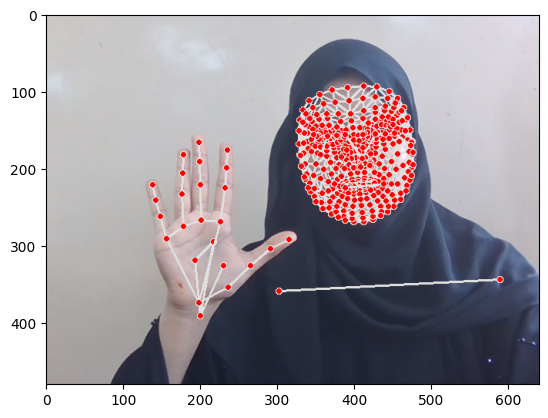

In [10]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

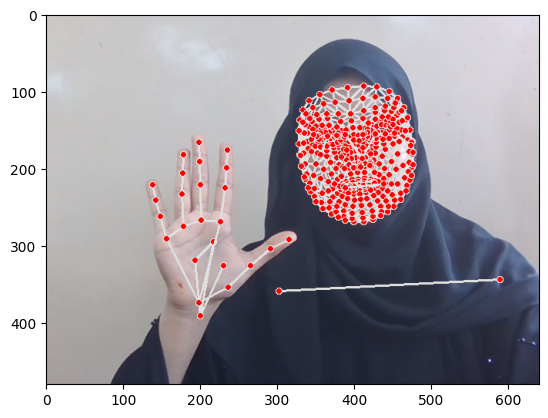

In [11]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [12]:
len(results.right_hand_landmarks.landmark)

21

In [13]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [14]:
# # Cell 6: Extract keypoints function
# def extract_keypoints(results):
#     # Normalize keypoints to handle different sizes and positions in the frame
#     pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
#     # face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
#     lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
#     rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    
#     # Concatenate pose, face, left hand, and right hand keypoints into a single vector
#     return np.concatenate([pose, lh, rh])

In [15]:
def extract_keypoints(results):
    """
    Extract pose, face, left hand, and right hand keypoints from MediaPipe results.
    results: MediaPipe holistic results object
    Returns: A NumPy array containing concatenated keypoints of shape (N,) 
             where N depends on which landmarks are detected.
    """
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    # face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    
    return np.concatenate([pose, lh, rh])

# Test the function
result_test = extract_keypoints(results)
print(f"result_test shape: {result_test.shape}")

result_test shape: (258,)


In [16]:
def extract_keypoints(frame_data):
    """
    Extract pose, left hand, and right hand keypoints from a NumPy array.
    frame_data: A NumPy array of shape (1662,) containing all keypoints.
    Returns: A NumPy array of shape (225,) containing only relevant keypoints.
    """
    # Pose keypoints (33 keypoints, 4 values each: x, y, z, visibility)
    pose = frame_data[:33 * 4]  # First 132 values
    
    # Left hand keypoints (21 keypoints, 3 values each: x, y, z)
    lh_start = 33 * 4  # Start index of left hand keypoints (after pose)
    lh_end = lh_start + 21 * 3  # End index of left hand keypoints
    lh = frame_data[lh_start:lh_end]
    
    # Right hand keypoints (21 keypoints, 3 values each: x, y, z)
    rh_start = lh_end  # Start index of right hand keypoints (after left hand)
    rh_end = rh_start + 21 * 3  # End index of right hand keypoints
    rh = frame_data[rh_start:rh_end]
    
    # Concatenate pose, left hand, and right hand keypoints into a single vector
    return np.concatenate([pose, lh, rh])

In [17]:
# Test the function
frame_data = np.random.rand(1662)  # Dummy data
relevant_keypoints = extract_keypoints(frame_data)
print(f"relevant_keypoints shape: {relevant_keypoints.shape}")  # Should be (225,)

relevant_keypoints shape: (258,)


In [18]:
# def extract_keypoints(keypoints):
#     # Extract the pose keypoints (first 33*4 values)
#     pose = keypoints[:33*4] if len(keypoints) >= 33*4 else np.zeros(33*4)

#     # Extract the face keypoints (next 468*3 values, even though we won't use them)
#     face = keypoints[33*4:33*4 + 468*3] if len(keypoints) >= 33*4 + 468*3 else np.zeros(468*3)

#     # Extract the left hand keypoints (next 21*3 values)
#     lh = keypoints[33*4 + 468*3:33*4 + 468*3 + 21*3] if len(keypoints) >= 33*4 + 468*3 + 21*3 else np.zeros(21*3)

#     # Extract the right hand keypoints (next 21*3 values)
#     rh = keypoints[33*4 + 468*3 + 21*3:33*4 + 468*3 + 42*3] if len(keypoints) >= 33*4 + 468*3 + 42*3 else np.zeros(21*3)

#     # Concatenate pose, face, left hand, and right hand keypoints into a single vector (face is still included but not used)
#     return np.concatenate([pose, lh, rh])

In [19]:
result_test

array([ 6.40878022e-01,  3.90758097e-01, -1.22723484e+00,  9.99978483e-01,
        6.67881131e-01,  3.24586093e-01, -1.15200138e+00,  9.99943912e-01,
        6.88365102e-01,  3.23576450e-01, -1.15191376e+00,  9.99925017e-01,
        7.07164824e-01,  3.22583407e-01, -1.15159202e+00,  9.99914944e-01,
        6.07134044e-01,  3.26819003e-01, -1.12706017e+00,  9.99955595e-01,
        5.89836240e-01,  3.27606201e-01, -1.12641501e+00,  9.99959290e-01,
        5.71271598e-01,  3.30014020e-01, -1.12683034e+00,  9.99970675e-01,
        7.39489079e-01,  3.54210049e-01, -6.49200499e-01,  9.99907553e-01,
        5.57115972e-01,  3.79170984e-01, -5.02456129e-01,  9.99969184e-01,
        6.84651494e-01,  4.59042370e-01, -1.04687726e+00,  9.99962986e-01,
        6.07739091e-01,  4.70391661e-01, -1.00877512e+00,  9.99965727e-01,
        9.20515060e-01,  7.18071818e-01, -2.10533470e-01,  9.96225297e-01,
        4.72691476e-01,  7.48039186e-01, -3.44495237e-01,  9.99733150e-01,
        1.00994635e+00,  

In [20]:
np.save('0', result_test)

In [21]:
data = np.load('0.npy')

In [22]:
# # Set print options to display the entire array without truncation
# np.set_printoptions(threshold=np.inf)
# # Print the content of the loaded array
# print(data)

In [23]:
# Cell 7: Data paths and actions
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('third_pov_DATA') 

# Actions that we try to detect
# actions = np.array(['hello', 'good', 'morning', 'thank you', 
# 'name', 'you', 'I', 'fullstop', 'work', 'engineer', 'from', 'okay', 
# 'fine', 'mumbai', 'live', 'how', 'what', 'who', 'iloveyou', 'no', 'stop'])

actions = np.array(['hello', 'good', 'morning', 'mumbai', 'you', 'name', 'I', 'stop','fullstop'])
# Thirty videos worth of data(Number of sequence/videos for each action)  
no_sequences = 100

# Videos are going to be 30 frames in length- frames per sequence
sequence_length = 30

start_folder = 1

In [24]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [25]:
label_map = {label:num for num, label in enumerate(actions)}

In [26]:
label_map

{'hello': 0,
 'good': 1,
 'morning': 2,
 'mumbai': 3,
 'you': 4,
 'name': 5,
 'I': 6,
 'stop': 7,
 'fullstop': 8}

In [28]:
import os

action_path = os.path.join(DATA_PATH, "hello")
if not os.path.exists(action_path):
    print(f"Error: Directory '{action_path}' does not exist!")
else:
    print(f"Directory exists: {action_path}")


Directory exists: third_pov_DATA\hello


In [29]:
import os

if not os.path.exists(DATA_PATH):
    print(f"Error: Base directory '{DATA_PATH}' does not exist!")
else:
    print(f"Base directory exists: {DATA_PATH}")
    print(f"Contents: {os.listdir(DATA_PATH)}")


Base directory exists: third_pov_DATA
Contents: ['engineer', 'fine', 'from', 'fullstop', 'good', 'hello', 'how', 'I', 'iloveyou', 'live', 'morning', 'mumbai', 'name', 'no', 'okay', 'stop', 'thank you', 'third_pov_DATA', 'what', 'who', 'work', 'you']


In [30]:
# Cell 8: Load and preprocess dataset
sequences, labels = [], []
for action in actions:
    print(f"Processing action: {action}")
    # Get all sequence filenames and sort them numerically
    sequence_files = sorted(os.listdir(os.path.join(DATA_PATH, action)), key=lambda x: int(x))[:no_sequences]
    
    for sequence in sequence_files:
        print(f"  - Loading sequence {sequence} for action {action}")
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            relevant_keypoints = extract_keypoints(res)
            window.append(relevant_keypoints)
        sequences.append(window)
        labels.append(label_map[action])

Processing action: hello
  - Loading sequence 1 for action hello
  - Loading sequence 2 for action hello
  - Loading sequence 3 for action hello
  - Loading sequence 4 for action hello
  - Loading sequence 5 for action hello
  - Loading sequence 6 for action hello
  - Loading sequence 7 for action hello
  - Loading sequence 8 for action hello
  - Loading sequence 9 for action hello
  - Loading sequence 10 for action hello
  - Loading sequence 11 for action hello
  - Loading sequence 12 for action hello
  - Loading sequence 13 for action hello
  - Loading sequence 14 for action hello
  - Loading sequence 15 for action hello
  - Loading sequence 16 for action hello
  - Loading sequence 17 for action hello
  - Loading sequence 18 for action hello
  - Loading sequence 19 for action hello
  - Loading sequence 20 for action hello
  - Loading sequence 21 for action hello
  - Loading sequence 22 for action hello
  - Loading sequence 23 for action hello
  - Loading sequence 24 for action hello


In [31]:
import os

action_path = os.path.join(DATA_PATH, "hello")
if not os.path.exists(action_path):
    print(f"Error: Directory '{action_path}' does not exist!")
else:
    print(f"Directory exists: {action_path}")


Directory exists: third_pov_DATA\hello


In [32]:
# # Load and preprocess dataset
# sequences, labels = [], []
# for action in actions:
#     print(f"Processing action: {action}")
#     sequence_files = sorted(os.listdir(os.path.join(DATA_PATH, action)), key=lambda x: int(x))[:no_sequences]
    
#     for sequence in sequence_files:
#         print(f"  - Loading sequence {sequence} for action {action}")
#         window = []
#         for frame_num in range(sequence_length):
#             res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
#             # Apply extract_keypoints to reduce the number of features
#             relevant_keypoints = extract_keypoints(res)
#             window.append(relevant_keypoints)
#         sequences.append(window)
#         labels.append(label_map[action])

# # Convert to numpy arrays
# X = np.array(sequences)
# y = to_categorical(labels, num_classes=len(actions))

# # Verify shapes
# print(f"X shape: {X.shape}")  # Should be (num_samples, 30, 225)
# print(f"y shape: {y.shape}")  # Should be (num_samples, num_classes)

In [33]:
# # Data loading and preprocessing with print statements for tracking progress
# sequences, labels = [], []

# print("Starting data loading...")

# # Loop through each action
# for action in actions:
#     print(f"Processing action: {action}")
#     # Loop through each sequence within the action
#     for sequence in range(1, no_sequences + 1):
#         print(f"  - Loading sequence {sequence} for action {action}")
#         window = []
#         # Loop through frames in the sequence
#         for frame_num in range(sequence_length):
#             try:
#                 # Load the frame and add it to the window (sequence)
#                 frame_path = os.path.join(DATA_PATH, action, str(sequence), f"{frame_num}.npy")
#                 frame = np.load(frame_path)
#                 keypoints = extract_keypoints(frame)
#                 window.append(keypoints)
#             except FileNotFoundError:
#                 # If the frame file is missing, print an error and pad with zeros
#                 print(f"File {frame_num}.npy not found for sequence {sequence}. Padding with zeros.")
#                 window.append(np.zeros(1662))  # Padding with zeros (assuming 1662 is the keypoint vector size)

#         sequences.append(window)  # Add the processed window (sequence of frames) to sequences
#         labels.append(label_map[action])  # Add the corresponding label for the action

#     print(f"Finished processing action: {action}")

# print("Data loading complete.")

# # Convert sequences and labels into numpy arrays
# X = np.array(sequences)
# y = np.array(labels)

# # Check the shape of the data arrays
# print(f"Data shapes: X: {X.shape}, y: {y.shape}")

In [36]:
np.array(sequences).shape

(900, 30, 258)

In [37]:
print("Frame data type:", type(frame_data))
print("Frame data shape:", frame_data.shape if isinstance(frame_data, np.ndarray) else "Not an array")


Frame data type: <class 'numpy.ndarray'>
Frame data shape: (1662,)


In [38]:
# import numpy as np

# def extract_keypoints(frame_data):
#     try:
#         print("Function called")
#         pose_start, pose_end = 0, 33 * 4  # 132
#         lh_start, lh_end = pose_end, pose_end + 21 * 4  # 132 to 216
#         rh_start, rh_end = lh_end, lh_end + 21 * 4  # 216 to 300

#         if frame_data is None:
#             print("Error: frame_data is None!")
#             return np.zeros(1662)  # Return a zero array instead of None

#         pose = frame_data[pose_start:pose_end]
#         lh = frame_data[lh_start:lh_end]
#         rh = frame_data[rh_start:rh_end]

#         print(f"Pose shape: {pose.shape}, Left hand shape: {lh.shape}, Right hand shape: {rh.shape}")

#         return np.concatenate([pose, lh, rh])

#     except Exception as e:
#         print("Error occurred:", e)
#         return np.zeros(1662)  # Always return a valid shape


In [39]:
# keypoints = extract_keypoints(results)
# print("Extracted keypoints shape:", keypoints.shape)  # Should be (1662,)


In [40]:
# if keypoints.shape[0] != 1662:
#     print(f"❌ Incorrect keypoints shape: {keypoints.shape}, skipping frame.")
#     continue


In [41]:
np.array(labels).shape

(900,)

In [42]:
X = np.array(sequences)

In [43]:
X.shape

(900, 30, 258)

In [44]:
# Cell 9: Convert labels to categorical 
# y = to_categorical(labels).astype(int)
y = to_categorical(labels, num_classes=len(actions))

In [45]:
y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [46]:
print(y.shape)

(900, 9)


In [47]:
# Cell 10: Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}") 
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (720, 30, 258), y_train shape: (720, 9)
X_test shape: (180, 30, 258), y_test shape: (180, 9)


In [49]:
print(y_test.shape)

(180, 9)


In [50]:
print(y_train.shape)

(720, 9)


In [51]:
print(X_train.shape)

(720, 30, 258)


In [52]:
print(X_test.shape)

(180, 30, 258)


In [53]:
# from tensorflow.keras.utils import to_categorical

# num_classes = 18  # Your updated number of output classes

# # Convert labels from (num_samples, 11) to (num_samples, 18)
# y_train = to_categorical(np.argmax(y_train, axis=1), num_classes=num_classes)
# y_test = to_categorical(np.argmax(y_test, axis=1), num_classes=num_classes)

# print(f"Updated y_train shape: {y_train.shape}")  # Should be (1045, 18)
# print(f"Updated y_test shape: {y_test.shape}")    # Should be (55, 18)


In [54]:
# from tensorflow.keras.models import Sequential 
# from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization 
# from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, LambdaCallback
# import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [54]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [55]:
# Setup the custom LambdaCallback to save model at every even epoch
checkpoint_dir = os.path.join('checkpoints_with_from&no')
os.makedirs(checkpoint_dir, exist_ok=True)

def save_at_even_epochs(epoch, logs):
    actual_epoch = epoch + 1
    if actual_epoch % 2 == 0:  # Check if epoch is even
        model.save(os.path.join(checkpoint_dir, f'model_epoch_{actual_epoch}.h5'))
        print(f"\n Saved model at epoch {actual_epoch}")

# Using LambdaCallback to save model at every even epoch
checkpoint_callback = LambdaCallback(on_epoch_end=save_at_even_epochs)

In [56]:
# #deepseek
# # Cell 25 (Updated Model Architecture)
# model = Sequential()
# model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(30, 1662)))  # Bidirectional layer
# model.add(Dropout(0.3))  # Regularization
# model.add(Bidirectional(LSTM(256, return_sequences=True))) 
# model.add(Dropout(0.2))
# model.add(Bidirectional(LSTM(128, return_sequences=False)))
# model.add(Dropout(0.3))
# model.add(Dense(128, activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(actions.shape[0], activation='softmax'))

In [57]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

# model = Sequential([
#     Bidirectional(LSTM(128, return_sequences=True, activation='relu'), input_shape=(30, 1662)),
#     Dropout(0.2),
    
#     Bidirectional(LSTM(256, return_sequences=True, activation='relu')),
#     Dropout(0.2),
    
#     Bidirectional(LSTM(256, return_sequences=False, activation='relu')),
#     Dropout(0.2),
    
#     Dense(128, activation='relu'),
#     Dense(64, activation='relu'),
    
#     Dense(18, activation='softmax')  # 🔥 Change 11 -> 18
# ])

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# model.summary()  # Verify that the output layer has (None, 18)


In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization , InputLayer
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Define the model
model = Sequential()

# Input layer (automatically inferred from input shape)
model.add(InputLayer(input_shape=(30, 258)))

# First LSTM layer
model.add(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())  # Normalize the activations
model.add(Dropout(0.5))  # Regularization to prevent overfitting

# Second LSTM layer
model.add(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Fully connected (Dense) layers
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))

# Output layer with softmax activation for multi-class classification
model.add(Dense(len(actions), activation='softmax'))  # Number of classes = len(actions)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Use Adam optimizer with a small learning rate
    loss='categorical_crossentropy',  # Loss function for multi-class classification
    metrics=['categorical_accuracy']  # Monitor accuracy during training
)

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30, 128)           198144    
                                                                 
 batch_normalization_2 (Bat  (None, 30, 128)           512       
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 batch_normalization_3 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 64)               

In [59]:
print(f"X_train shape: {X_train.shape}")  # Should be (num_samples, 30, 1662)
print(f"y_train shape: {y_train.shape}")  # Should be (num_samples, 11) for one-hot encoded labels
print(f"X_test shape: {X_test.shape}")    # Should be (num_samples, 30, 1662)
print(f"y_test shape: {y_test.shape}")    # Should be (num_samples, 11) for one-hot encoded labels

X_train shape: (560, 30, 258)
y_train shape: (560, 7)
X_test shape: (140, 30, 258)
y_test shape: (140, 7)


In [60]:
# # Custom learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [61]:
history = model.fit(X_train, y_train, 
                    epochs=500, 
                    validation_data=(X_test, y_test),
                    batch_size=32,
                    callbacks=[tb_callback, checkpoint_callback])

Epoch 1/500


18/18 [==============================] - 15s 198ms/step - loss: 8.4790 - categorical_accuracy: 0.2000 - val_loss: 7.6658 - val_categorical_accuracy: 0.1714
Epoch 2/500
17/18 [===========================>..] - ETA: 0s - loss: 8.3831 - categorical_accuracy: 0.2022
 Saved model at epoch 2
18/18 [==============================] - 1s 66ms/step - loss: 8.3780 - categorical_accuracy: 0.2000 - val_loss: 7.6061 - val_categorical_accuracy: 0.1857
Epoch 3/500


C:\Users\aaliy\OneDrive\Desktop\sign\sign\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


18/18 [==============================] - 1s 59ms/step - loss: 7.9976 - categorical_accuracy: 0.2750 - val_loss: 7.5438 - val_categorical_accuracy: 0.2429
Epoch 4/500
18/18 [==============================] - ETA: 0s - loss: 7.8744 - categorical_accuracy: 0.2589
 Saved model at epoch 4
18/18 [==============================] - 1s 72ms/step - loss: 7.8744 - categorical_accuracy: 0.2589 - val_loss: 7.4724 - val_categorical_accuracy: 0.2929
Epoch 5/500
18/18 [==============================] - 1s 63ms/step - loss: 7.7171 - categorical_accuracy: 0.2732 - val_loss: 7.4030 - val_categorical_accuracy: 0.2643
Epoch 6/500
18/18 [==============================] - ETA: 0s - loss: 7.6963 - categorical_accuracy: 0.2893
 Saved model at epoch 6
18/18 [==============================] - 1s 67ms/step - loss: 7.6963 - categorical_accuracy: 0.2893 - val_loss: 7.3354 - val_categorical_accuracy: 0.2643
Epoch 7/500
18/18 [==============================] - 1s 61ms/step - loss: 7.5545 - categorical_accuracy: 0.303

In [62]:
history = model.fit(X_train, y_train, 
                    epochs=1000, 
                    initial_epoch=500,
                    validation_data=(X_test, y_test),
                    batch_size=32,
                    callbacks=[tb_callback, checkpoint_callback])

Epoch 501/1000
18/18 [==============================] - 1s 62ms/step - loss: 0.6176 - categorical_accuracy: 0.9732 - val_loss: 1.3218 - val_categorical_accuracy: 0.7786
Epoch 502/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.6084 - categorical_accuracy: 0.9816
 Saved model at epoch 502
18/18 [==============================] - 1s 59ms/step - loss: 0.6067 - categorical_accuracy: 0.9821 - val_loss: 1.4237 - val_categorical_accuracy: 0.7714
Epoch 503/1000
18/18 [==============================] - 1s 59ms/step - loss: 0.5641 - categorical_accuracy: 0.9875 - val_loss: 2.0516 - val_categorical_accuracy: 0.7143
Epoch 504/1000
18/18 [==============================] - ETA: 0s - loss: 0.5690 - categorical_accuracy: 0.9911
 Saved model at epoch 504
18/18 [==============================] - 1s 63ms/step - loss: 0.5690 - categorical_accuracy: 0.9911 - val_loss: 1.3616 - val_categorical_accuracy: 0.8000
Epoch 505/1000
18/18 [==============================] - 1s 57ms/step - loss: 0.576

In [63]:
history = model.fit(X_train, y_train, 
                    epochs=1500, 
                    initial_epoch=1001,
                    validation_data=(X_test, y_test),
                    batch_size=32,
                    callbacks=[tb_callback, checkpoint_callback])

Epoch 1002/1500
17/18 [===========================>..] - ETA: 0s - loss: 0.2578 - categorical_accuracy: 0.9945
 Saved model at epoch 1002
18/18 [==============================] - 1s 66ms/step - loss: 0.2584 - categorical_accuracy: 0.9946 - val_loss: 1.2180 - val_categorical_accuracy: 0.7786
Epoch 1003/1500
18/18 [==============================] - 1s 60ms/step - loss: 0.2695 - categorical_accuracy: 0.9911 - val_loss: 1.8383 - val_categorical_accuracy: 0.6786
Epoch 1004/1500
18/18 [==============================] - ETA: 0s - loss: 0.2781 - categorical_accuracy: 0.9929
 Saved model at epoch 1004
18/18 [==============================] - 1s 62ms/step - loss: 0.2781 - categorical_accuracy: 0.9929 - val_loss: 1.1534 - val_categorical_accuracy: 0.8071
Epoch 1005/1500
18/18 [==============================] - 1s 54ms/step - loss: 0.2515 - categorical_accuracy: 0.9964 - val_loss: 1.2482 - val_categorical_accuracy: 0.8143
Epoch 1006/1500
17/18 [===========================>..] - ETA: 0s - loss: 0.2

In [64]:
history = model.fit(X_train, y_train, 
                    epochs=2000, 
                    initial_epoch=1501,
                    validation_data=(X_test, y_test),
                    batch_size=32,
                    callbacks=[tb_callback, checkpoint_callback])

Epoch 1502/2000
17/18 [===========================>..] - ETA: 0s - loss: 0.2563 - categorical_accuracy: 0.9761
 Saved model at epoch 1502
18/18 [==============================] - 1s 66ms/step - loss: 0.2535 - categorical_accuracy: 0.9768 - val_loss: 1.4853 - val_categorical_accuracy: 0.6286
Epoch 1503/2000
18/18 [==============================] - 1s 56ms/step - loss: 0.2033 - categorical_accuracy: 0.9857 - val_loss: 1.0860 - val_categorical_accuracy: 0.7929
Epoch 1504/2000
17/18 [===========================>..] - ETA: 0s - loss: 0.1785 - categorical_accuracy: 0.9926
 Saved model at epoch 1504
18/18 [==============================] - 1s 66ms/step - loss: 0.1777 - categorical_accuracy: 0.9929 - val_loss: 1.5408 - val_categorical_accuracy: 0.7071
Epoch 1505/2000
18/18 [==============================] - 1s 57ms/step - loss: 0.1876 - categorical_accuracy: 0.9964 - val_loss: 0.5080 - val_categorical_accuracy: 0.9000
Epoch 1506/2000
18/18 [==============================] - ETA: 0s - loss: 0.1

In [117]:
evaluation= model.evaluate(X_test, y_test, verbose=2)
print(f"test loss: {evaluation[0]}, test accuracy: {evaluation[1]}")

2/2 - 0s - loss: 0.0133 - categorical_accuracy: 1.0000 - 192ms/epoch - 96ms/step
test loss: 0.013297106139361858, test accuracy: 1.0


In [118]:
# evaluation= model.evaluate(X_test, y_test, verbose=2)
# print(f"test loss: {evaluation[0]}, test accuracy: {evaluation[1]}")

In [119]:
res = model.predict(X_test)

2/2 [==============================] - 1s 96ms/step


In [120]:
print(res)

[[1.86180807e-10 4.11474321e-09 3.73816483e-13 7.05056152e-12
  3.75982093e-11 5.53891555e-09 1.24232387e-11 2.79047214e-07
  8.90480578e-09 2.32061329e-14 9.99999762e-01 2.64843977e-14
  7.71373423e-16 1.69964954e-15 1.18772275e-17 1.28168420e-18
  5.01704398e-18 1.22740226e-20]
 [4.15085631e-12 1.96475247e-21 1.13684141e-23 1.00000000e+00
  1.41431319e-14 1.42858455e-18 1.65244825e-12 3.22771831e-16
  1.50847557e-09 1.07679159e-23 1.77156399e-20 1.26170275e-26
  9.49630141e-26 3.60927555e-25 6.83683185e-24 3.13508335e-20
  2.26390837e-23 7.55947764e-27]
 [9.99992490e-01 1.67353189e-08 5.12312748e-10 3.81272798e-07
  6.00929573e-09 3.58158090e-08 3.77336448e-07 1.18648842e-07
  5.56930217e-08 6.57910414e-06 6.56704899e-12 4.60363081e-09
  1.18136261e-14 4.81650852e-13 2.62872307e-10 3.98450328e-10
  9.70883041e-10 2.99854477e-12]
 [2.34083986e-04 6.81398978e-06 1.18802896e-08 1.16090393e-09
  1.53974743e-05 7.83933228e-06 7.25018268e-08 2.27215118e-03
  1.30217104e-05 7.18754167e-10 9

In [121]:
actions[np.argmax(res[0])]

'okay'

In [122]:
actions[np.argmax(y_test[0])]

'okay'

# Train Log

In [123]:
model.save('./checkpoints-1.06am-13dec/March12.h5')

# Post Training

In [ ]:
# import numpy as np

# # Assuming y_train contains the labels
# class_counts = np.sum(y_train, axis=0)
# print("Class counts:", class_counts)

In [ ]:
# pip install seaborn==0.12.2

In [ ]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# y_pred = model.predict(X_test)
# y_pred_classes = np.argmax(y_pred, axis=1)
# y_true_classes = np.argmax(y_test, axis=1)

# cm = confusion_matrix(y_true_classes, y_pred_classes)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=actions, yticklabels=actions)
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()

In [129]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30, 128)           198144    
                                                                 
 batch_normalization_2 (Bat  (None, 30, 128)           512       
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 batch_normalization_3 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 64)               

In [57]:
model.load_weights('C:\\Users\\aaliy\\OneDrive\\Desktop\\sign\\checkpoints_\\model_epoch_1432.h5')

In [58]:
res = model.predict(X_test)

6/6 [==============================] - 3s 22ms/step


In [59]:
actions[np.argmax(res[0])]

'hello'

In [60]:
actions[np.argmax(y_test[0])]

'hello'

In [61]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [62]:
yhat = model.predict(X_test)

6/6 [==============================] - 0s 22ms/step


In [63]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [64]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[155,   0],
        [  0,  25]],

       [[167,   0],
        [  0,  13]],

       [[158,   0],
        [  1,  21]],

       [[158,   0],
        [  0,  22]],

       [[157,   1],
        [  2,  20]],

       [[157,   0],
        [  0,  23]],

       [[162,   2],
        [  0,  16]],

       [[162,   0],
        [  0,  18]],

       [[161,   0],
        [  0,  19]]], dtype=int64)

In [65]:
accuracy_score(ytrue, yhat)

0.9833333333333333

In [139]:
# Evaluate the model 
loss, accuracy = model.evaluate(X_test, y_test) 
print(f'Loss: {loss}, Accuracy: {accuracy}')



6/6 [==============================] - 4s 21ms/step - loss: 0.2622 - categorical_accuracy: 0.9833
Loss: 0.26216229796409607, Accuracy: 0.9833333492279053


In [134]:
# FURTHER USE THIRD_POV-NLU FILE FOR INFERENCE

In [140]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30, 128)           198144    
                                                                 
 batch_normalization_2 (Bat  (None, 30, 128)           512       
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 batch_normalization_3 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 64)               

In [ ]:
# from sklearn.metrics import classification_report, confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np

# # Predictions
# y_pred = model.predict(X_test)
# y_pred_classes = np.argmax(y_pred, axis=1)
# y_true_classes = np.argmax(y_test, axis=1)

# # Confusion Matrix
# cm = confusion_matrix(y_true_classes, y_pred_classes)

# # Plot
# plt.figure(figsize=(10, 7))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=actions, yticklabels=actions)
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()

# # Classification Report
# print("Classification Report:\n")
# print(classification_report(y_true_classes, y_pred_classes, target_names=actions))


In [ ]:
# from sklearn.manifold import TSNE

# # Extract penultimate layer outputs (Dense before softmax)
# from tensorflow.keras.models import Model

# # Create a model that outputs the penultimate layer (i.e., before softmax)
# penultimate_layer_model = Model(inputs=model.input, outputs=model.layers[-2].output)

# # Get features for X_test
# penultimate_features = penultimate_layer_model.predict(X_test)

# # Run t-SNE on these features
# tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto')
# tsne_results = tsne.fit_transform(penultimate_features)

# # Plot the 2D t-SNE representation
# plt.figure(figsize=(10, 7))
# for i, action in enumerate(actions):
#     indices = np.where(y_true_classes == i)
#     plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], label=action, alpha=0.6)

# plt.legend()
# plt.title("t-SNE Visualization of Feature Space")
# plt.xlabel("t-SNE Dimension 1")
# plt.ylabel("t-SNE Dimension 2")
# plt.grid(True)
# plt.tight_layout()
# plt.show()


In [ ]:
# plt.savefig("tsne_feature_space.png", dpi=300)


In [66]:
from scipy import stats

In [67]:
import random
actions = np.array(['hello', 'good', 'morning', 'mumbai', 'you', 'name', 'I', 'stop','fullstop'])

colors = [tuple(random.randint(0, 255) for _ in range(3)) for _ in range(len(actions))]  # Random colors
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    
    # Ensure res, actions, and colors have the same length
    num_actions = len(actions)
    if len(res) != num_actions:
        print(f"Warning: The number of probabilities ({len(res)}) does not match the number of actions ({num_actions})")
    
    for num, prob in enumerate(res):
        if isinstance(prob, (list, np.ndarray)): # If prob is an array, take the first element 
            prob = prob[0]
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [143]:
# import cv2
# import mediapipe as mp

# cap = cv2.VideoCapture(1)

# if not cap.isOpened():
#     print("Error: Could not open camera.")
#     exit()

# mp_holistic = mp.solutions.holistic
# with mp_holistic.Holistic(min_detection_confidence=0.3, min_tracking_confidence=0.3) as holistic:
#     while cap.isOpened():
#         ret, frame = cap.read()
#         if not ret:
#             print("Error: Failed to grab frame.")
#             break

#         cv2.imshow('OpenCV Feed', frame)

#         if cv2.waitKey(30) & 0xFF == ord('q'):
#             break

# cap.release()
# cv2.destroyAllWindows()


In [144]:
# import time
# start_time = time.time()
# res = model.predict(np.expand_dims(sequence, axis=0))[0]
# print(f"Prediction time: {time.time() - start_time:.2f} sec")


In [68]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.7
last_action_time = 0  # Track when the last action was detected
action_cooldown = 1.0  # Minimum time (in seconds) between actions

# url = 'http://192.168.63.28:5000/video_feed'
# cap = cv2.VideoCapture(url, cv2.CAP_FFMPEG)
# Cell 6: Extract keypoints function
def extract_keypoints(results):
    # Normalize keypoints to handle different sizes and positions in the frame
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    
    # Concatenate pose, face, left hand, and right hand keypoints into a single vector
    return np.concatenate([pose, lh, rh])

cap = cv2.VideoCapture(0)

# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    frame_count = 0

    while cap.isOpened():
        current_time = time.time()  # Get current time
        
        # Read feed
        ret, frame = cap.read()
        
        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            predicted_index = np.argmax(res)
            
            # Only process if confidence is above threshold and cooldown has passed
            if res[predicted_index] > threshold and (current_time - last_action_time) > action_cooldown:
                # ✅ Ensure index is within valid range
                if predicted_index < len(actions):
                    print(actions[predicted_index])
                    predictions.append(predicted_index)
                    
                    # Update last action time
                    last_action_time = current_time
                    
                    #3. Viz logic
                    if np.unique(predictions[-10:])[0] == predicted_index: 
                        if len(sentence) > 0: 
                            if actions[predicted_index] != sentence[-1]:
                                sentence.append(actions[predicted_index])
                        else:
                            sentence.append(actions[predicted_index])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
            
cap.release()
cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [151]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.7

# url = 'http://192.168.63.28:5000/video_feed'
# cap = cv2.VideoCapture(url, cv2.CAP_FFMPEG)
# Cell 6: Extract keypoints function
def extract_keypoints(results):
    # Normalize keypoints to handle different sizes and positions in the frame
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    
    # Concatenate pose, face, left hand, and right hand keypoints into a single vector
    return np.concatenate([pose, lh, rh])

cap = cv2.VideoCapture(0)

# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    frame_count = 0

    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        # if not ret:
        #     print("❌ No frame captured")
        #     break  # Instead of continue, break the loop if the camera is stuck
    
        # frame_count += 1
        # if frame_count % 10 == 0:
        #     print(f"Processed {frame_count} frames...")

        
        # ret, frame = cap.read()
        # if not ret:
        #     print("Failed to capture frame")
        #     continue  # Skip processing if frame is invalid

        # print(f"Frame processing time: {time.time() - start_time:.2f} sec")
        # time.sleep(0.01)

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            import time
            # start_time = time.time() 
            res = model.predict(np.expand_dims(sequence, axis=0))[0]

            predicted_index = np.argmax(res)

            # ✅ Ensure index is within valid range
            if predicted_index >= len(actions):
                print(f"❌ Invalid prediction index: {predicted_index}, skipping")
            else:
                print(actions[predicted_index])
                predictions.append(predicted_index)

            # prediction_time = time.time() - start_time  # End timing
            # print(f"Prediction time: {prediction_time:.2f} sec")  # Print prediction time
    
            # print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
cap.releaseq
cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>


AttributeError: 'cv2.VideoCapture' object has no attribute 'releaseq'

In [149]:
cap.release()
cv2.destroyAllWindows()

In [70]:
# pred_index = np.argmax(res)
# if pred_index >= len(actions):  # Prevents index error
#     print(f"Warning: Model predicted {pred_index}, but actions has {len(actions)} classes.")
#     continue  # Skip this frame

# print(actions[pred_index])  # Now safe


In [100]:
# print(f"res.shape: {res.shape}")  # Should match (18,)
# print(f"np.argmax(res): {np.argmax(res)}")  # Should be within 0-17
# print(f"len(actions): {len(actions)}")  # Should be 18


res.shape: (55, 11)
np.argmax(res): 336
len(actions): 18


In [28]:
# model = Sequential()
# model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,258)))
# model.add(LSTM(128, return_sequences=True, activation='relu'))
# model.add(Dropout(0.3))
# model.add(LSTM(64, return_sequences=False, activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(actions.shape[0], activation='softmax'))

In [29]:
# model = Sequential()
# model.add(LSTM(128, return_sequences=True, activation='relu', input_shape=(sequence_length, 1662)))  # Increased units
# model.add(LSTM(256, return_sequences=True, activation='relu'))  # Added another LSTM layer with more units
# model.add(Dropout(0.3))  # Adjusted Dropout
# model.add(LSTM(128, return_sequences=False, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(128, activation='relu'))  # Increased Dense layer units
# model.add(Dropout(0.5))  # Increased dropout to prevent overfitting
# model.add(Dense(actions.shape[0], activation='softmax'))


In [27]:
# from tensorflow.keras.layers import Bidirectional
# from keras.optimizers import Adam
# from keras.callbacks import ReduceLROnPlateau

In [28]:

# model = Sequential()
# model.add(Bidirectional(LSTM(128, return_sequences=True, activation='tanh', input_shape=(30, 1662))))
# model.add(Dropout(0.3))
# model.add(Bidirectional(LSTM(128, return_sequences=False, activation='tanh')))
# model.add(Dropout(0.3))
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(actions.shape[0], activation='softmax'))
# optimizer = Adam(learning_rate=0.001)
# model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
# optimizer = Adam(learning_rate=0.001) 
# model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
# lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

In [31]:
# # Learning rate scheduler 
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay( 
#     initial_learning_rate=1e-3, 
#     decay_steps=10000, 
#     decay_rate=0.95 )

In [32]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule) 
# loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

In [33]:
# model.compile(optimizer=optimizer, loss=loss, metrics=['categorical_accuracy'])